In [1]:
%load_ext autoreload
%autoreload 2
import smact.core as core
import smact.properties.Band_gap_simple as band_gap
import smact.lattice_parameters as lattice_parameters
import numpy as np
import os
import csv
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import hinton_colour as hinton



In [2]:
# get correct path for datafiles when called from another directory
smact_directory = '/Users/keith/SCRIPTS/smact/smact'
# Append a trailing slash to make coherent directory name - this would select the
# root directory in the case of no prefix, so we need to check
if smact_directory:
    smact_directory = smact_directory + '/'

In [3]:
def radius_covalent(element):
    with open(smact_directory + 'data/Covalent_radii.csv','rU') as f:
        reader = csv.reader(f)
        reader.next() # Skip the first row which is titles
        r_covalent=0
        for row in reader:
            symbols= list(row[0])
            # Some symbols specify a shell e.g. "Cu(d)"; we can ignore this part
            for char in symbols:
                if char == '(':
                    a=symbols.index("(")
                    symbols = symbols[:a]
            symbols="".join(symbols)
            if symbols == element:
                r_covalent = float(row[3])/ 100
    return r_covalent

In [4]:
def formal_charge(element):
    """Given an elemental symbol, return a list of available oxidation states"""
    with open(smact_directory + 'data/oxidation_states.txt','r') as f:
        data = f.readlines()
        oxidation_states = False
        for line in data:
            if not line.startswith('#'):
                l = line.split()
                if (l[0] == element):
                    if len(l)>1:
                        oxidation_states = l[1:]
                        for location, value in enumerate(oxidation_states):
                            oxidation_states[location] = int(value)
                    else:
                        oxidation_states = []
    return oxidation_states

In [5]:
def radius_shannon(element,oxidation):
    with open(smact_directory + 'data/shannon_radii.csv','rU') as f:
        reader = csv.reader(f)
        r_shannon=False
        for row in reader:
            if element == row[0] and float(oxidation)==float(row[1]) and row[2]=='4_n': #only for Wurtzite
                r_shannon=row[3]
    return r_shannon

In [6]:
output=[]
lattice_charge=-1
upper_n = 45
lower_n = 1
search_space = core.ordered_elements(lower_n,upper_n+1)
HHIp_grid = np.zeros(shape=(upper_n,upper_n))
Tol_grid  = np.zeros(shape=(upper_n,upper_n))
Eg_grid   = np.zeros(shape=(upper_n,upper_n))
HHIr_grid = np.zeros(shape=(upper_n,upper_n))
all_elements=[]
element_set=core.ordered_elements(lower_n,upper_n)

In [7]:
# Form a separate complete list of elements for quickly accessing proton numbers with index()
with open(smact_directory + 'data/ordered_periodic.txt','rU') as f:
    reader = csv.reader(f)
    for row in reader:
        all_elements.append(row[0])

In [8]:
tetra_coord_elements=[]
for element in element_set:
    with open(smact_directory + 'data/shannon_radii.csv','rU') as f:
        reader = csv.reader(f)
        r_shannon=False
        for row in reader:
            if row[2]=="4_n" and row[0]==element and row[0] not in tetra_coord_elements:
                tetra_coord_elements.append(row[0])

In [9]:
list_of_candidates = []
for a_element in tetra_coord_elements:
    for a_ox in core.Element(a_element).oxidation_states:
        for b_element in tetra_coord_elements:
            if core.Element(b_element).number > core.Element(a_element).number:
                for b_ox in core.Element(b_element).oxidation_states:
                    if b_ox + a_ox == -1:
                        radius_a = core.Element(a_element).covalent_radius*100
                        radius_b = core.Element(b_element).covalent_radius*100
                        pore = (radius_a + radius_b)*np.sin(np.radians(109.5))\
                        /np.sin(np.radians(30.25))
                        tolerance = 217*2/pore
                        HHI_prod = (int(core.Element(a_element).HHI_p) \
                        + int(core.Element(b_element).HHI_p))/2
                        list_of_candidates.append([a_element,b_element,\
                        tolerance, HHI_prod])
                        HHIp_grid[core.Element(a_element).number,core.Element(b_element).number] = \
                        HHI_prod
                        Tol_grid[core.Element(a_element).number,core.Element(b_element).number] = \
                        tolerance
                        sep = \
                        core.Element(a_element).covalent_radius+core.Element(b_element).covalent_radius
                        if a_ox < b_ox: # A is the anion
                            Eg = band_gap.band_gap_simple(Anion=a_element,Cation=b_element,Distance=sep)
                        else:
                            Eg = band_gap.band_gap_simple(Anion=b_element,Cation=a_element,Distance=sep)
                        HHI_res = (int(core.Element(a_element).HHI_R) \
                        + int(core.Element(b_element).HHI_R))/2
                        HHIr_grid[core.Element(b_element).number,core.Element(a_element).number] = \
                        HHI_res
                        Eg_grid[core.Element(b_element).number,core.Element(a_element).number] = \
                        Eg

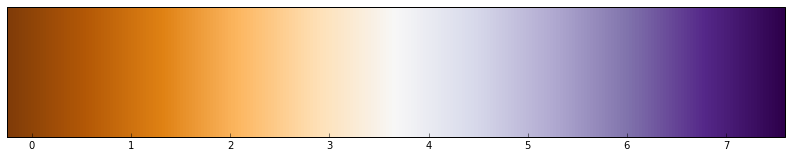

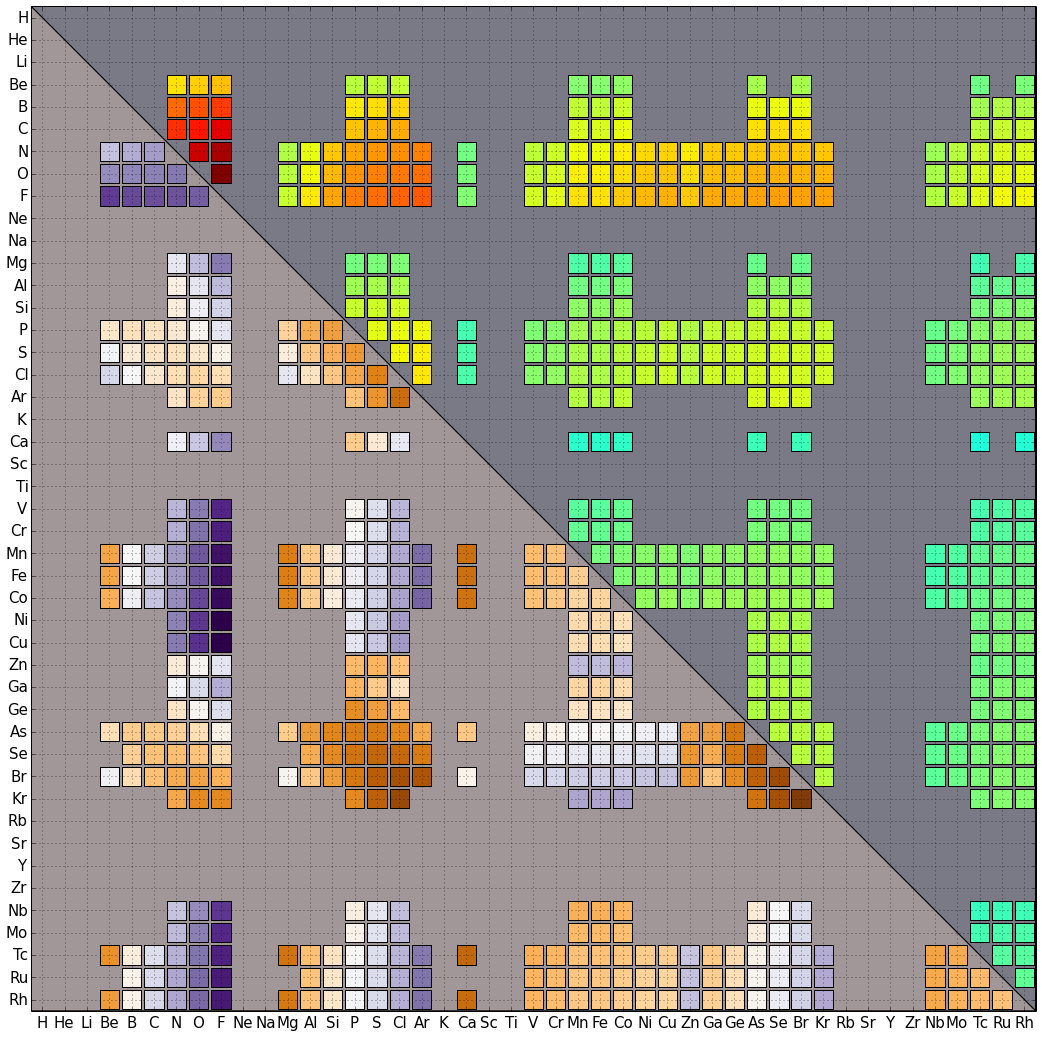

In [13]:
#fig, (ax1,ax2) = plt.subplots(2)
#fig, ax1 = plt.subplots()
%matplotlib inline
hinton.hinton_2D(Tol_grid,HHIp_grid,Eg_grid,HHIr_grid,maxweight=2)
#print search_space
mpl.pyplot.xticks(np.arange(lower_n-0.5,upper_n+0.5),search_space)

search_space.reverse()
#print search_space[0::1]
mpl.pyplot.yticks(np.arange(lower_n-0.5,upper_n+0.5),search_space[0::1])


search_space.reverse()
plt.tick_params(axis='both', which='major', labelsize=15)
plt.axis('on')
plt.grid(True)
plt.axes = plt.gca()
plt.axes.set_xlim([0,len(HHIp_grid)])
plt.axes.set_ylim([0,len(HHIp_grid)])
fig = plt.gcf()
fig.set_size_inches(18,18)
fig = plt.gcf()
#fig.set_size_inches(21,8)
plt.savefig('Eg-Tol.eps',dpi=300)



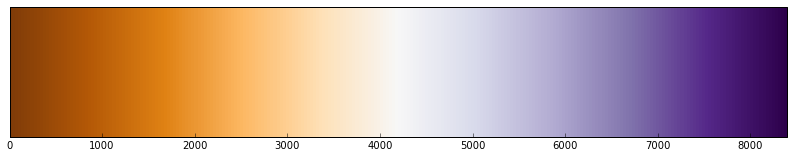

/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/backends/backend_pdf.py:2184: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  different = bool(ours != theirs)


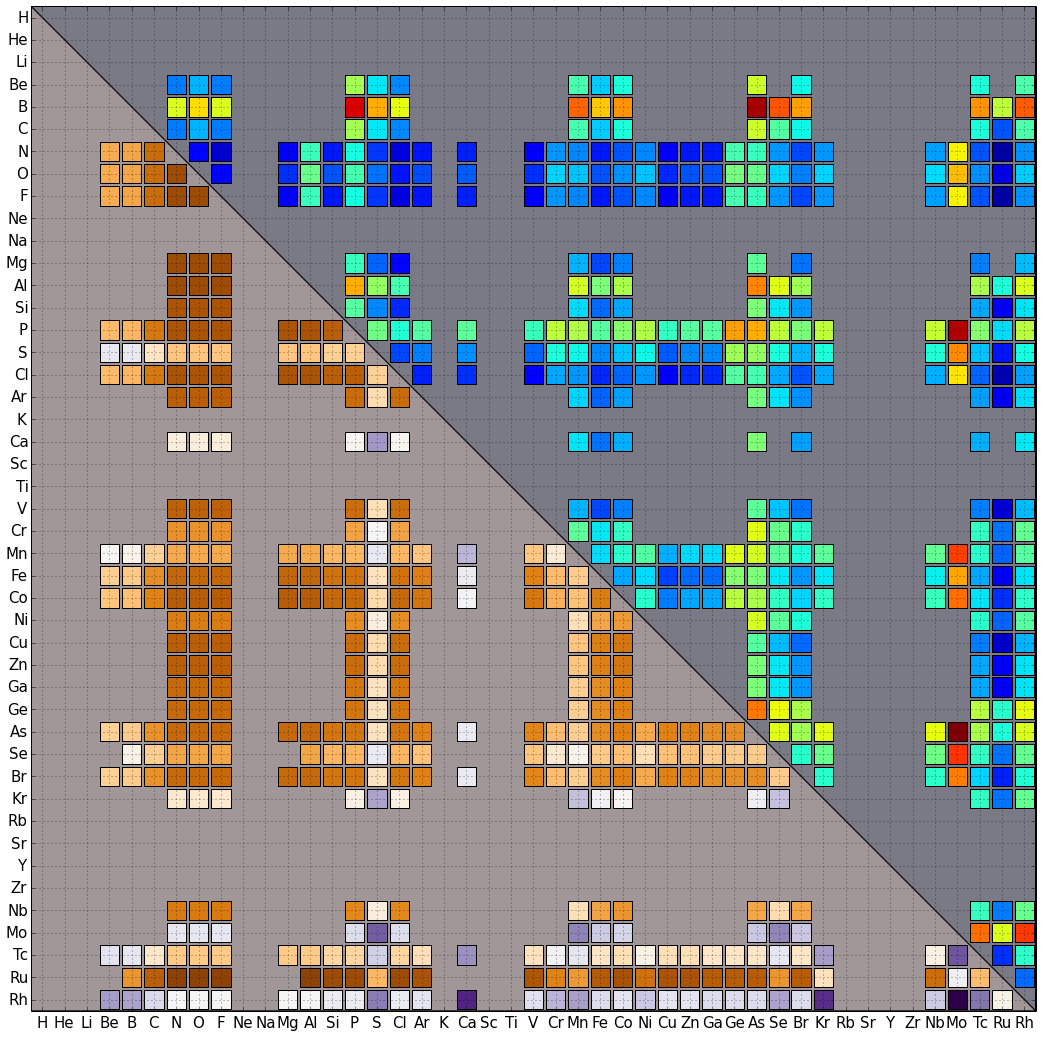

In [12]:
hinton.hinton_2D(HHIp_grid,Tol_grid,HHIr_grid,Eg_grid,maxweight=2)
mpl.pyplot.xticks(np.arange(lower_n-0.5,upper_n+0.5),search_space)
search_space.reverse()
mpl.pyplot.yticks(np.arange(lower_n-0.5,upper_n+0.5),search_space[0::1])
search_space.reverse()
plt.tick_params(axis='both', which='major', labelsize=15)
plt.axis('on')
plt.grid(True)
plt.axes = plt.gca()
plt.axes.set_xlim([0,len(HHIp_grid)])
plt.axes.set_ylim([0,len(HHIp_grid)])
fig = plt.gcf()
fig.set_size_inches(18,18)
fig = plt.gcf()
plt.savefig('HHI.pdf',dpi=600)

In [351]:
plt.show()

In [330]:
outfile = open('candidate_stuffed_wurtzite.csv','wb')
writer=csv.writer(outfile)
for row in list_of_candidates:
    writer.writerow(row)

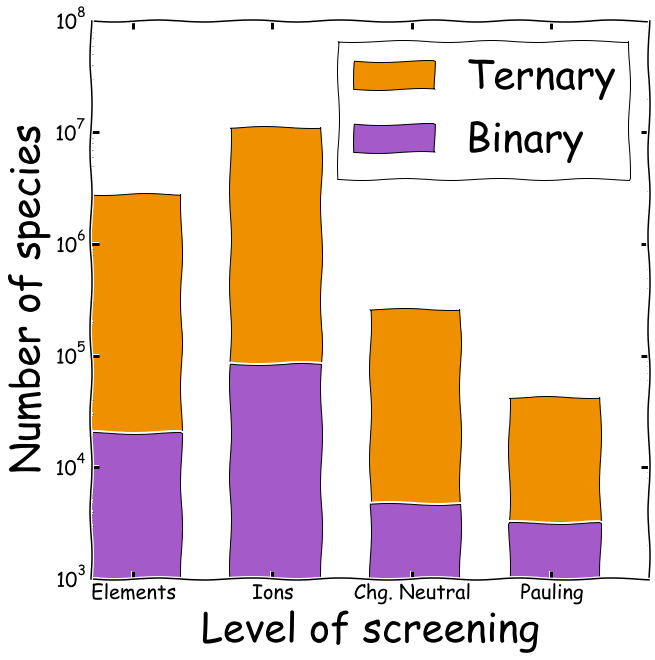

In [383]:
ternary_stats = (2794287,11258697,259231,42882)
binary_stats = (20357, 84103, 4635, 3151)
N = 4
width = 0.65
plt.xkcd()
ind = np.arange(N)
fig, ax = plt.subplots()
p1 = plt.bar(ind, ternary_stats,   width, color='#ef9000')
p2 = plt.bar(ind, binary_stats,   width, color='#a45ac9')
plt.ylabel('Number of species',fontsize=40)
plt.xlabel('Level of screening',fontsize=40)
ax.set_yscale('log')
for label in ax.get_xticklabels():
      label.set_fontsize(20)
for label in ax.get_yticklabels():
      label.set_fontsize(20)

plt.legend( (p1[0], p2[0]), ('Ternary', 'Binary'),fontsize=40)
plt.xticks(ind + 0.3, ('Elements', 'Ions', 'Chg. Neutral', 'Pauling'))
fig.set_size_inches(10,10)
plt.savefig('Counting.pdf')
plt.show()